In [14]:
from pymatgen.io.cif import CifParser
from pymatgen.io.ase import AseAtomsAdaptor
from ase.geometry.analysis import Analysis
from itertools import combinations_with_replacement, cycle, product, permutations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from pymatgen.core import Lattice, Structure
from pymatgen.core.composition import Composition

In [15]:
def split(word):
    data = [char for char in word]
    data = [x for x in data if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]   
    return data

In [16]:
cif_filepath = r"C:\Users\Calum\Documents\Coding\Python\PDielec_Dev\PDielec\IVDWFiles\D2TestFiles\Concatenated\D2.cif"

In [17]:
class BondsAngles:
# this class reads in a cif file and calculates all possible bond lengths, angles and dihredal 
# angles and plots them as violin plots
    def __init__(self, cif_filepath):
        self.cif_filepath = cif_filepath
        self.struct = None
        self.cell = None
        self.atoms = None
        self.analysis = None
        self.composition = None
        self.bonds = None
        self.angles = None
        self.dihedrals = None
        self.bonds_df = None
        self.angles_df = None
        self.dihedrals_df = None
        self.bonds_df_sns = None
        self.angles_df_sns = None
        self.dihedrals_df_sns = None
        
    def parse_cif(self):
        # parses CIF file and takes atom positions
        parser = CifParser(self.cif_filepath)
        self.struct = parser.get_structures()[0]
        self.cell = self.struct.lattice.matrix
        self.atoms = AseAtomsAdaptor.get_atoms(self.struct)
        self.analysis = Analysis(self.atoms)
        self.composition = split(self.struct.composition.reduced_formula)
    
    def produce_bonds_angles_dihedral_labels(self):
        # produces all possible combinations of bond, angle and dihredal labels and removed duplicates
        comp = split(self.struct.composition.reduced_formula)
        self.bonds = list(combinations_with_replacement(comp, 2))
        self.angles = list(product(comp, repeat=3))
        self.dihedrals = list(product(comp, repeat=4))
        
        perm = list(permutations(comp, 3))
        perm = perm[:len(comp)]
        comb_replace = list(combinations_with_replacement(comp, 3))
        for index, tuple in enumerate(comb_replace):
            if tuple[0] == tuple[1] and tuple[1] == tuple[2]:
              comb_replace.remove(tuple)
        for element in comb_replace:
            if element in self.angles:
                self.angles.remove(element)
        for element in perm:
            if element in self.angles:
                self.angles.remove(element)
                
        perm = list(permutations(comp, 4))
        perm = perm[:len(comp)]
        comb_replace = list(combinations_with_replacement(comp, 4))
        for index, tuple in enumerate(comb_replace):
            if tuple[0] == tuple[1] and tuple[1] == tuple[2] and tuple[2] == tuple[3]:
              comb_replace.remove(tuple)  
        for element in comb_replace:
            if element in self.dihedrals:
                self.dihedrals.remove(element)
        for element in perm:
            if element in self.dihedrals:
                self.dihedrals.remove(element)
                
    def calculate_bonds_angles_dihedrals(self):
        # calculates length or angle for each label
        data = {"Atoms":[],"Atom Numbers":[],"Bond Length":[]};
        for i in range(len(self.bonds)):
            a, b = self.bonds[i]
            bond_list = self.analysis.get_bonds(a, b, unique=True)
            temp = bond_list[0]
            if temp:
                bondvalues = self.analysis.get_values(bond_list)
                bondvalues = bondvalues[0]
                data["Atoms"].append(self.bonds[i])
                data["Atom Numbers"].append(temp)
                data["Bond Length"].append(bondvalues)
        self.bonds_df = pd.DataFrame(data)
        self.bonds_df_sns = self.bonds_df.drop(['Atom Numbers'], axis=1)
        self.bonds_df_sns = self.bonds_df_sns.explode('Bond Length')
        self.bonds_df_sns['Bond Length'] = self.bonds_df_sns['Bond Length'].astype('float')
        self.bonds_df_sns = self.bonds_df_sns.set_index('Atoms')

        data = {"Atoms":[],"Atom Numbers":[],"Bond Angles":[]};
        for i in range(len(self.angles)):
            a, b, c = self.angles[i]
            angles_list = self.analysis.get_angles(a, b, c, unique=True)
            temp = angles_list[0]
            if temp:
                anglevalues = self.analysis.get_values(angles_list)
                data["Atoms"].append(self.angles[i])
                data["Atom Numbers"].append(temp)
                data["Bond Angles"].append(anglevalues)
        self.angles_df = pd.DataFrame(data)
        self.angles_df_sns = self.angles_df.drop(['Atom Numbers'], axis=1)
        self.angles_df_sns = self.angles_df_sns.explode('Bond Angles')
        self.angles_df_sns = self.angles_df_sns.explode('Bond Angles')
        self.angles_df_sns['Bond Angles'] = self.angles_df_sns['Bond Angles'].astype('float')
        self.angles_df_sns = self.angles_df_sns.set_index('Atoms')
        self.angles_df_sns = self.angles_df_sns.loc[(self.angles_df_sns['Bond Angles']>20) & 
                                                    (self.angles_df_sns['Bond Angles']< 143)]

        data = {"Atoms":[],"Atom Numbers":[],"Dihedrals":[]};
        for i in range(len(self.dihedrals)):
            a, b, c, d = self.dihedrals[i]
            dihedrals_list = self.analysis.get_dihedrals(a, b, c, d, unique=True)
            temp = dihedrals_list[0]
            if temp:
                dihedralsvalues = self.analysis.get_values(dihedrals_list)
                data["Atoms"].append(self.dihedrals[i])
                data["Atom Numbers"].append(temp)
                data["Dihedrals"].append(dihedralsvalues)
        self.dihedrals_df = pd.DataFrame(data)
        self.dihedrals_df_sns = self.dihedrals_df.drop(['Atom Numbers'], axis=1)
        self.dihedrals_df_sns = self.dihedrals_df_sns.explode('Dihedrals')
        self.dihedrals_df_sns = self.dihedrals_df_sns.explode('Dihedrals')
        self.dihedrals_df_sns['Dihedrals'] = self.dihedrals_df_sns['Dihedrals'].astype('float')
        self.dihedrals_df_sns = self.dihedrals_df_sns.set_index('Atoms')
        self.dihedrals_df_sns = self.dihedrals_df_sns.loc[(self.dihedrals_df_sns['Dihedrals']>20) &
                                                          (self.dihedrals_df_sns['Dihedrals']< 179.99999)]
        count_freq = dict(self.dihedrals_df_sns.index.value_counts())
        self.dihedrals_df_sns['count_freq'] = self.dihedrals_df_sns.index
        self.dihedrals_df_sns['count_freq'] = self.dihedrals_df_sns['count_freq'].map(count_freq)
        self.dihedrals_df_sns = self.dihedrals_df_sns[self.dihedrals_df_sns.count_freq>4]
        
    def plot_bonds(self):
        # produces violin plots for each bond type
        nplots = len(self.bonds_df["Atoms"])
        if nplots <= 6:
            ncol = 2
        elif nplots <= 9:
            ncol = 3
        elif nplots <= 16:
            ncol = 4
        nrow = int(nplots / ncol) + (nplots % ncol > 0)
        sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
        palette = cycle(sns.color_palette("hls", 8))
        fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
        counter = 0
        for j in self.bonds_df["Atoms"]:
            sns.violinplot(y="Bond Length", data=self.bonds_df_sns.loc[[j]], ax=ax.flat[counter],
                           color=next(palette)).set_title([j])
            counter += 1
        if (nplots % ncol > 0) == 1:
            ax.flat[-1].set_visible(False)
        plt.tight_layout()
        plt.show();
        
    def plot_angles(self):
        # produces violin plots for each angle type
        nplots = len(set(self.angles_df_sns.index.tolist()))
        if nplots <= 6:
            ncol = 2
        elif nplots <= 9:
            ncol = 3
        elif nplots <= 16:
            ncol = 4
        nrow = int(nplots / ncol) + (nplots % ncol > 0)
        sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
        palette = cycle(sns.color_palette("hls", 8))
        fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
        counter = 0
        for j in self.angles_df["Atoms"]:
            if j in self.angles_df_sns.index:
                
                sns.violinplot(y="Bond Angles", data=self.angles_df_sns.loc[[j]], ax=ax.flat[counter], 
                               label=[j], color=next(palette)).set_title([j])
                counter += 1
        if (nplots % ncol > 0) == 1:
            ax.flat[-1].set_visible(False)
        plt.tight_layout()
        plt.show()
    
    def plot_dihedrals(self):
        # produces violin plots for each dihedral type
        nplots = len(set(self.dihedrals_df_sns.index.tolist()))
        if nplots <= 6:
            ncol = 2
        elif nplots <= 9:
            ncol = 3
        elif nplots <= 16:
            ncol = 4
        nrow = int(nplots / 4) + (nplots % 4 > 0)
        sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
        palette = cycle(sns.color_palette("hls", 8))
        fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
        counter = 0
        for j in self.dihedrals_df["Atoms"]:
            if j in self.dihedrals_df_sns.index:
                sns.violinplot(y="Dihedrals", data=self.dihedrals_df_sns.loc[[j]], ax=ax.flat[counter], 
                               color=next(palette)).set_title([j])
                counter += 1
        if (nplots % ncol > 0) == 1:
            ax.flat[-1].set_visible(False)
        plt.tight_layout()
        plt.show();

In [18]:
D2 = BondsAngles(cif_filepath)
D2.parse_cif()
D2.produce_bonds_angles_dihedral_labels()
D2.calculate_bonds_angles_dihedrals()

In [23]:
D2.angles_df

,Atoms,Atom Numbers,Bond Angles
0,"(H, C, H)","[(7, 58, 8), (6, 59, 9), (16, 70, 39), (17, 71...","[[108.14226948335231, 108.14226948335246, 108...."
1,"(H, O, H)","[(14, 90, 28), (15, 91, 29)]","[[104.82845577275766, 104.82845577275762]]"
2,"(C, C, H)","[(50, 48, 19), (56, 48, 19), (51, 49, 18), (57...","[[108.10843049875727, 109.73935224942593, 108...."
3,"(C, C, C)","[(50, 48, 56), (51, 49, 57), (48, 50, 61), (49...","[[109.94784804444454, 109.9478480444447, 111.1..."
4,"(C, O, H)","[(67, 72, 2), (66, 73, 3), (56, 78, 5), (57, 7...","[[106.90257889459258, 106.90257889459231, 111...."
5,"(C, O, C)","[(54, 74, 60), (55, 75, 61), (51, 76, 63), (50...","[[113.10136595130896, 113.10136595130898, 116...."
6,"(O, C, H)","[(86, 48, 19), (87, 49, 18), (77, 50, 22), (76...","[[109.4425224348014, 109.44252243480125, 110.0..."
7,"(O, C, C)","[(86, 48, 50), (86, 48, 56), (87, 49, 51), (87...","[[111.59297047883733, 108.00047635987913, 111...."
8,"(O, C, O)","[(74, 54, 92), (75, 55, 93), (77, 62, 84), (76...","[[111.82302830778531, 111.82302830778532, 107...."


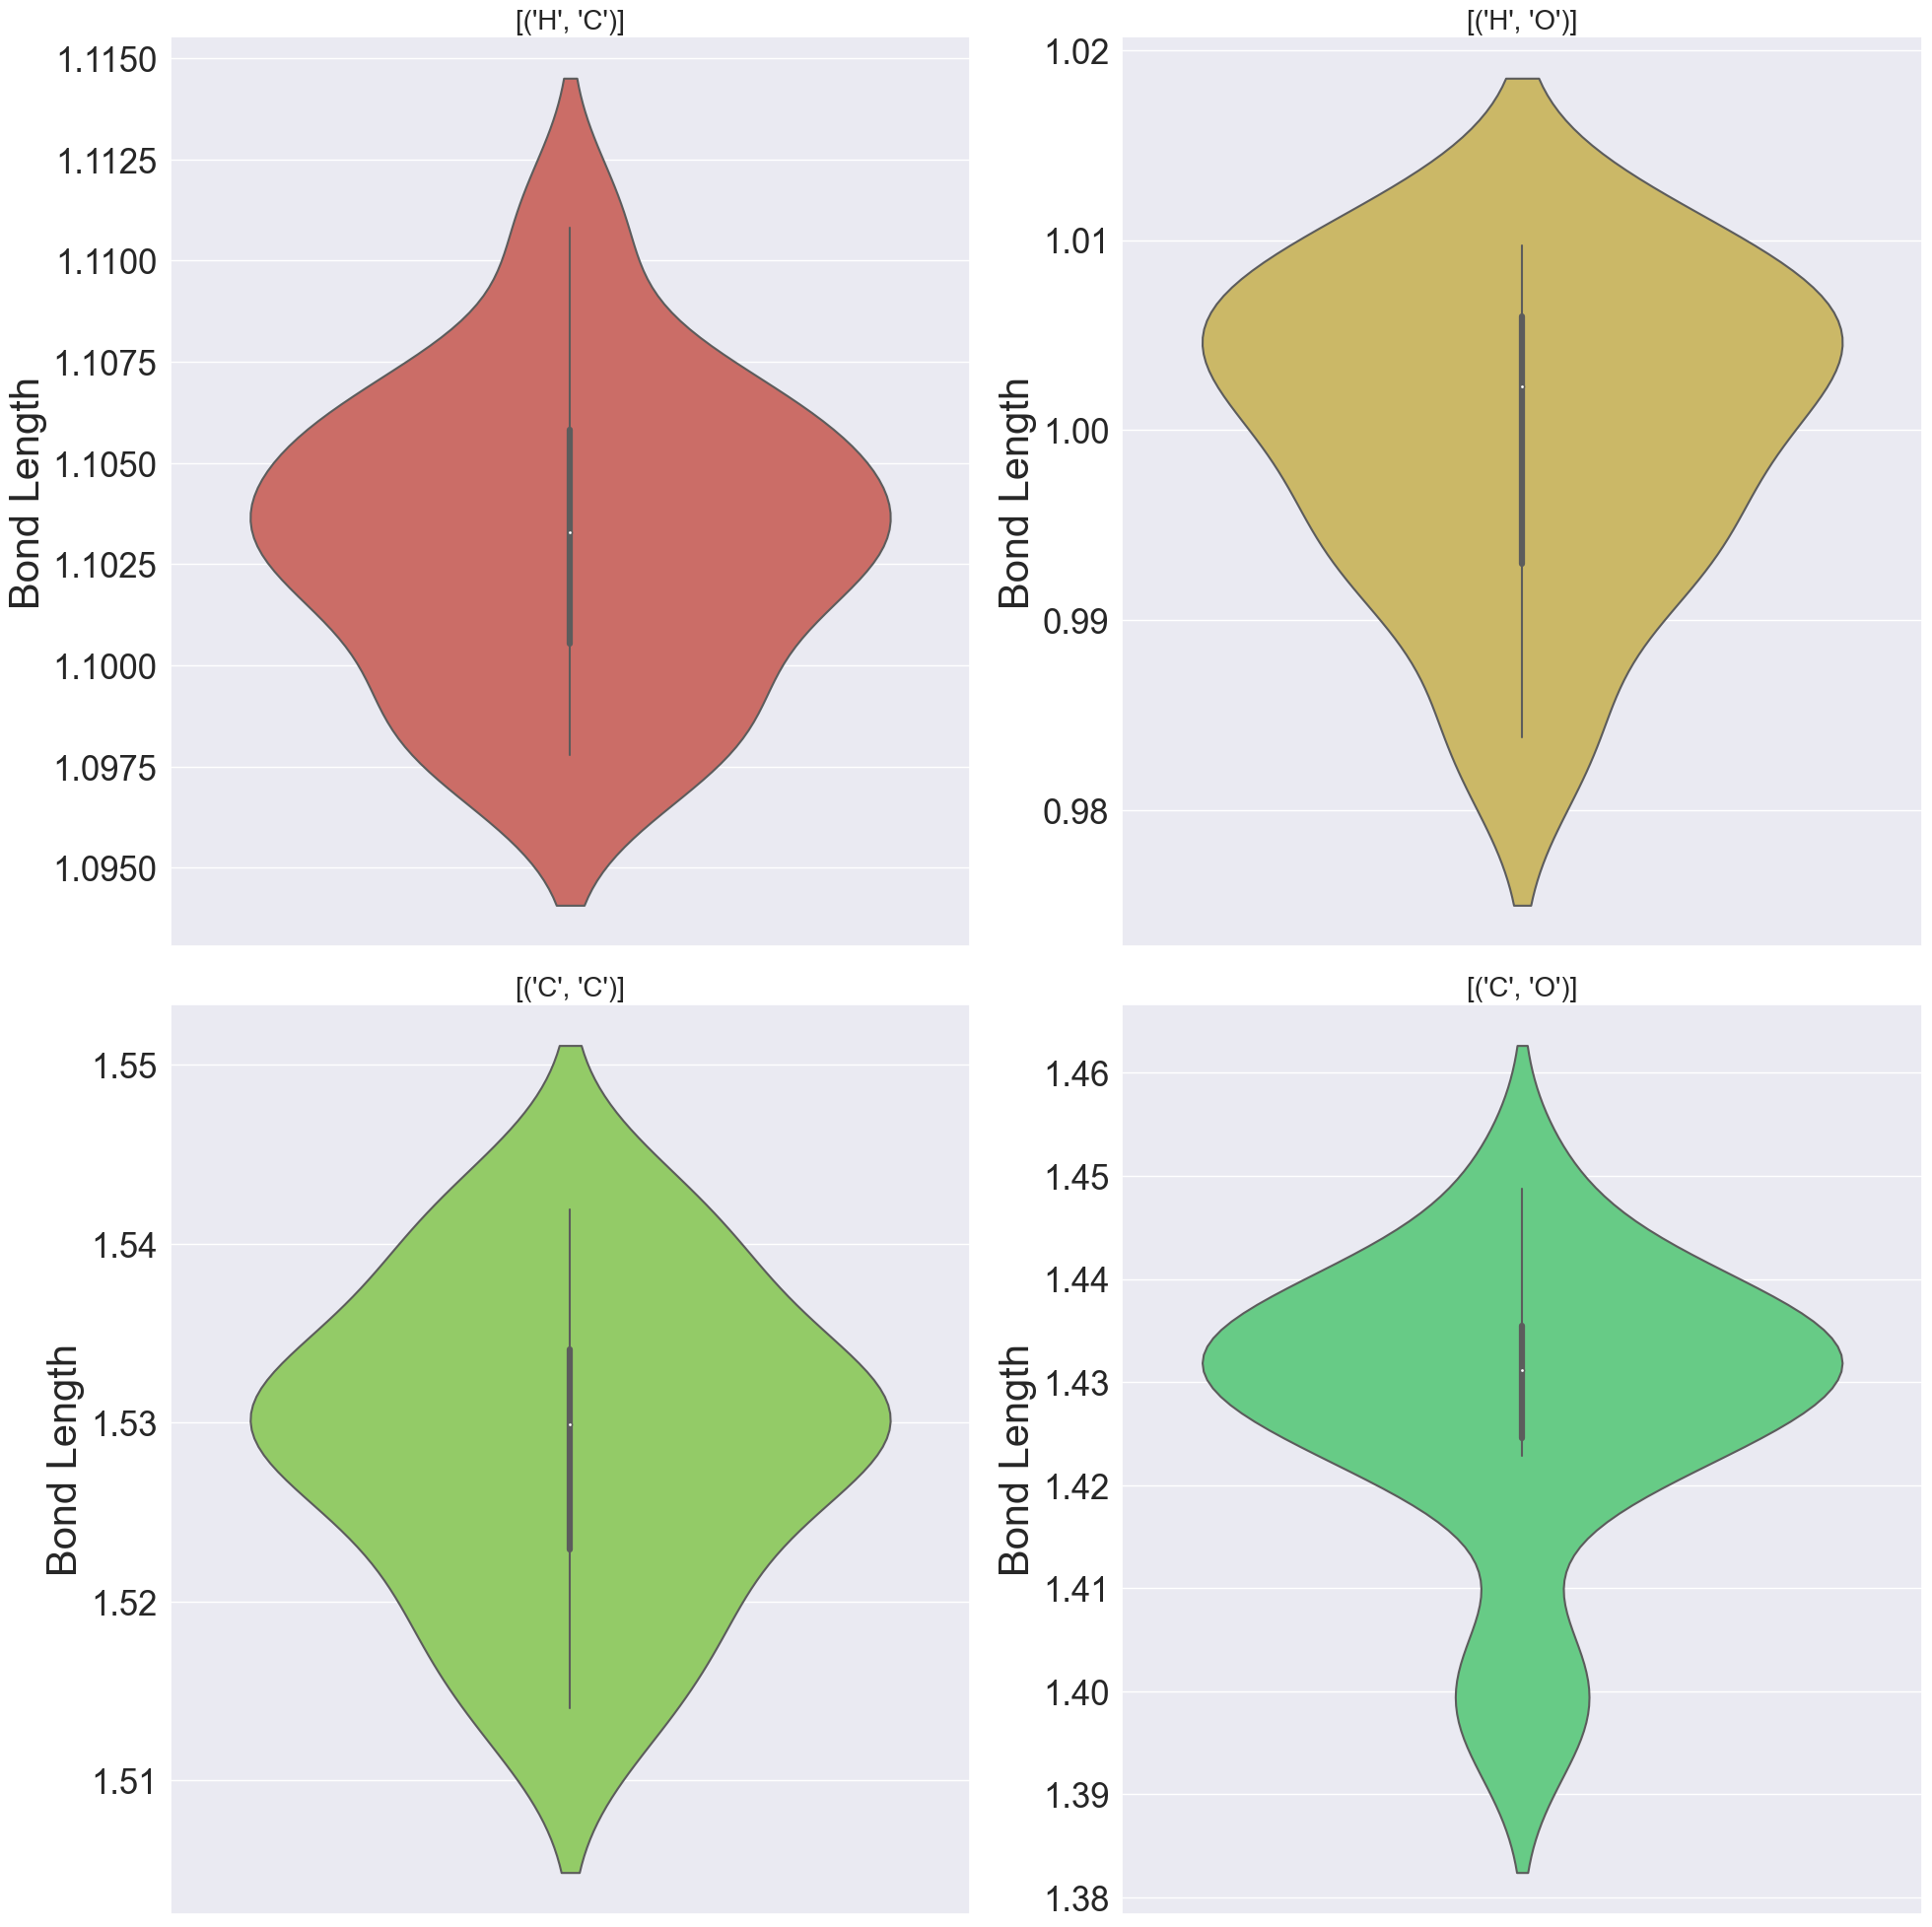

In [6]:
D2.plot_bonds()

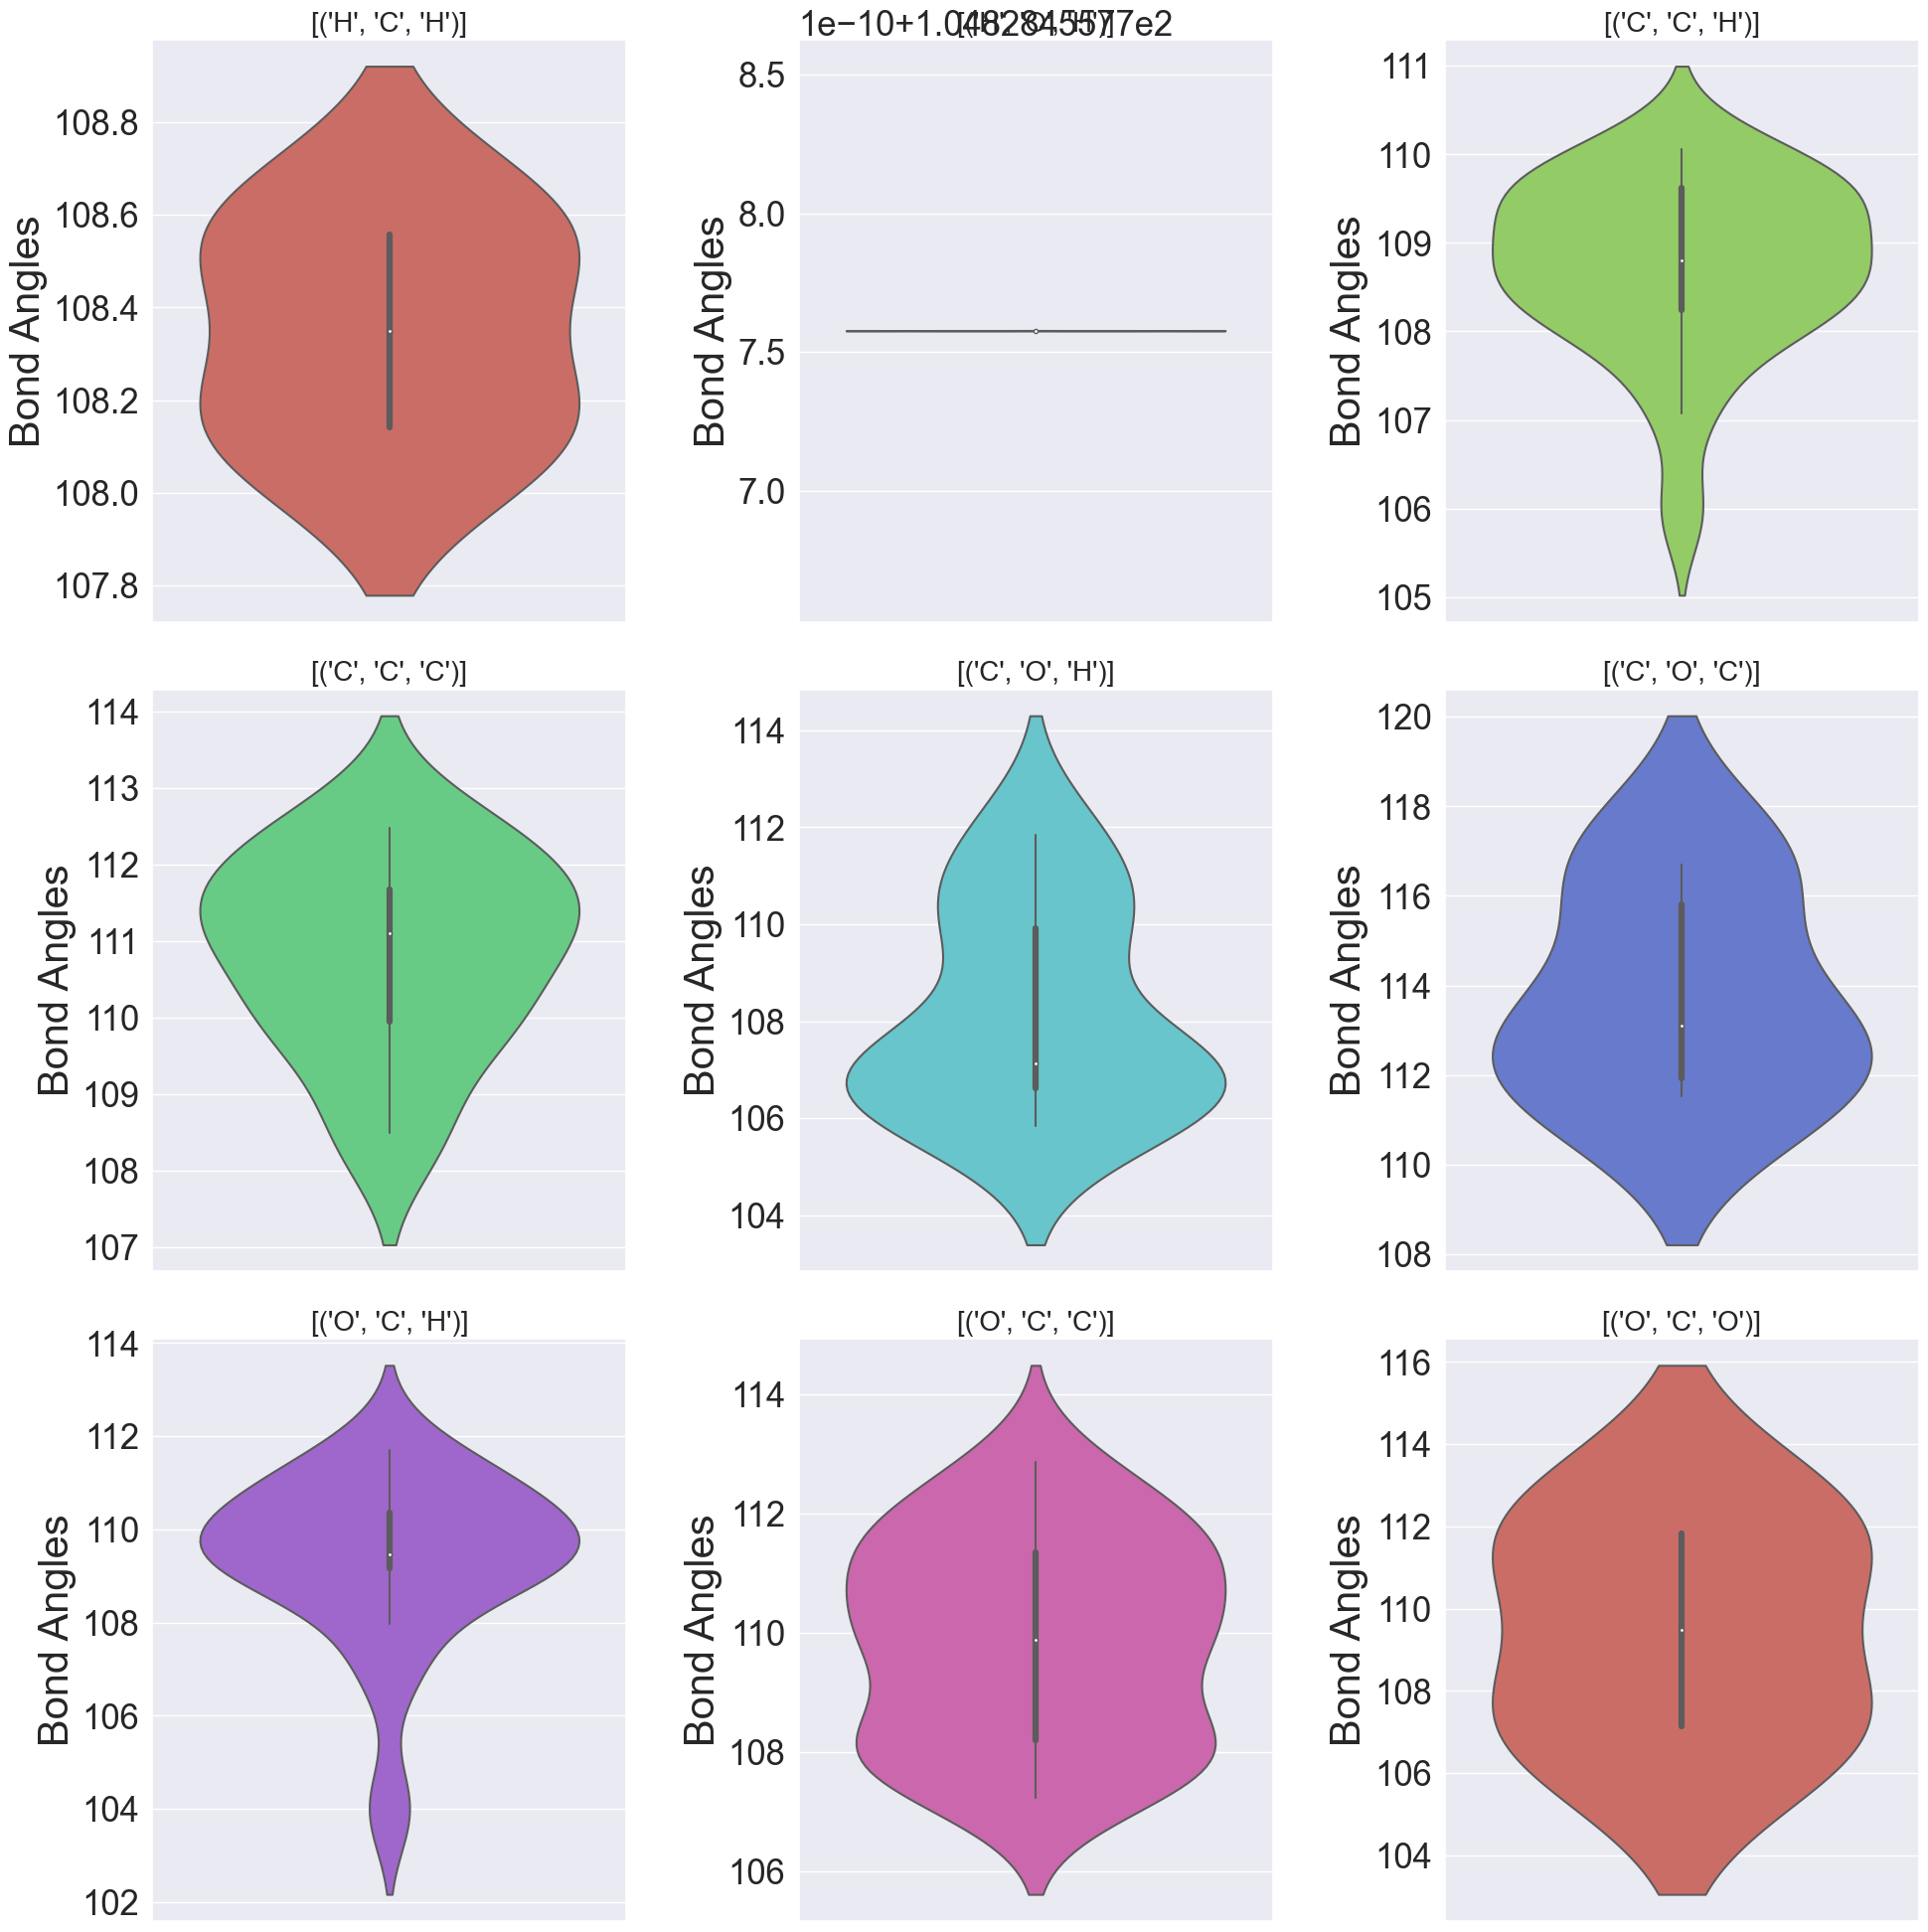

In [7]:
D2.plot_angles()

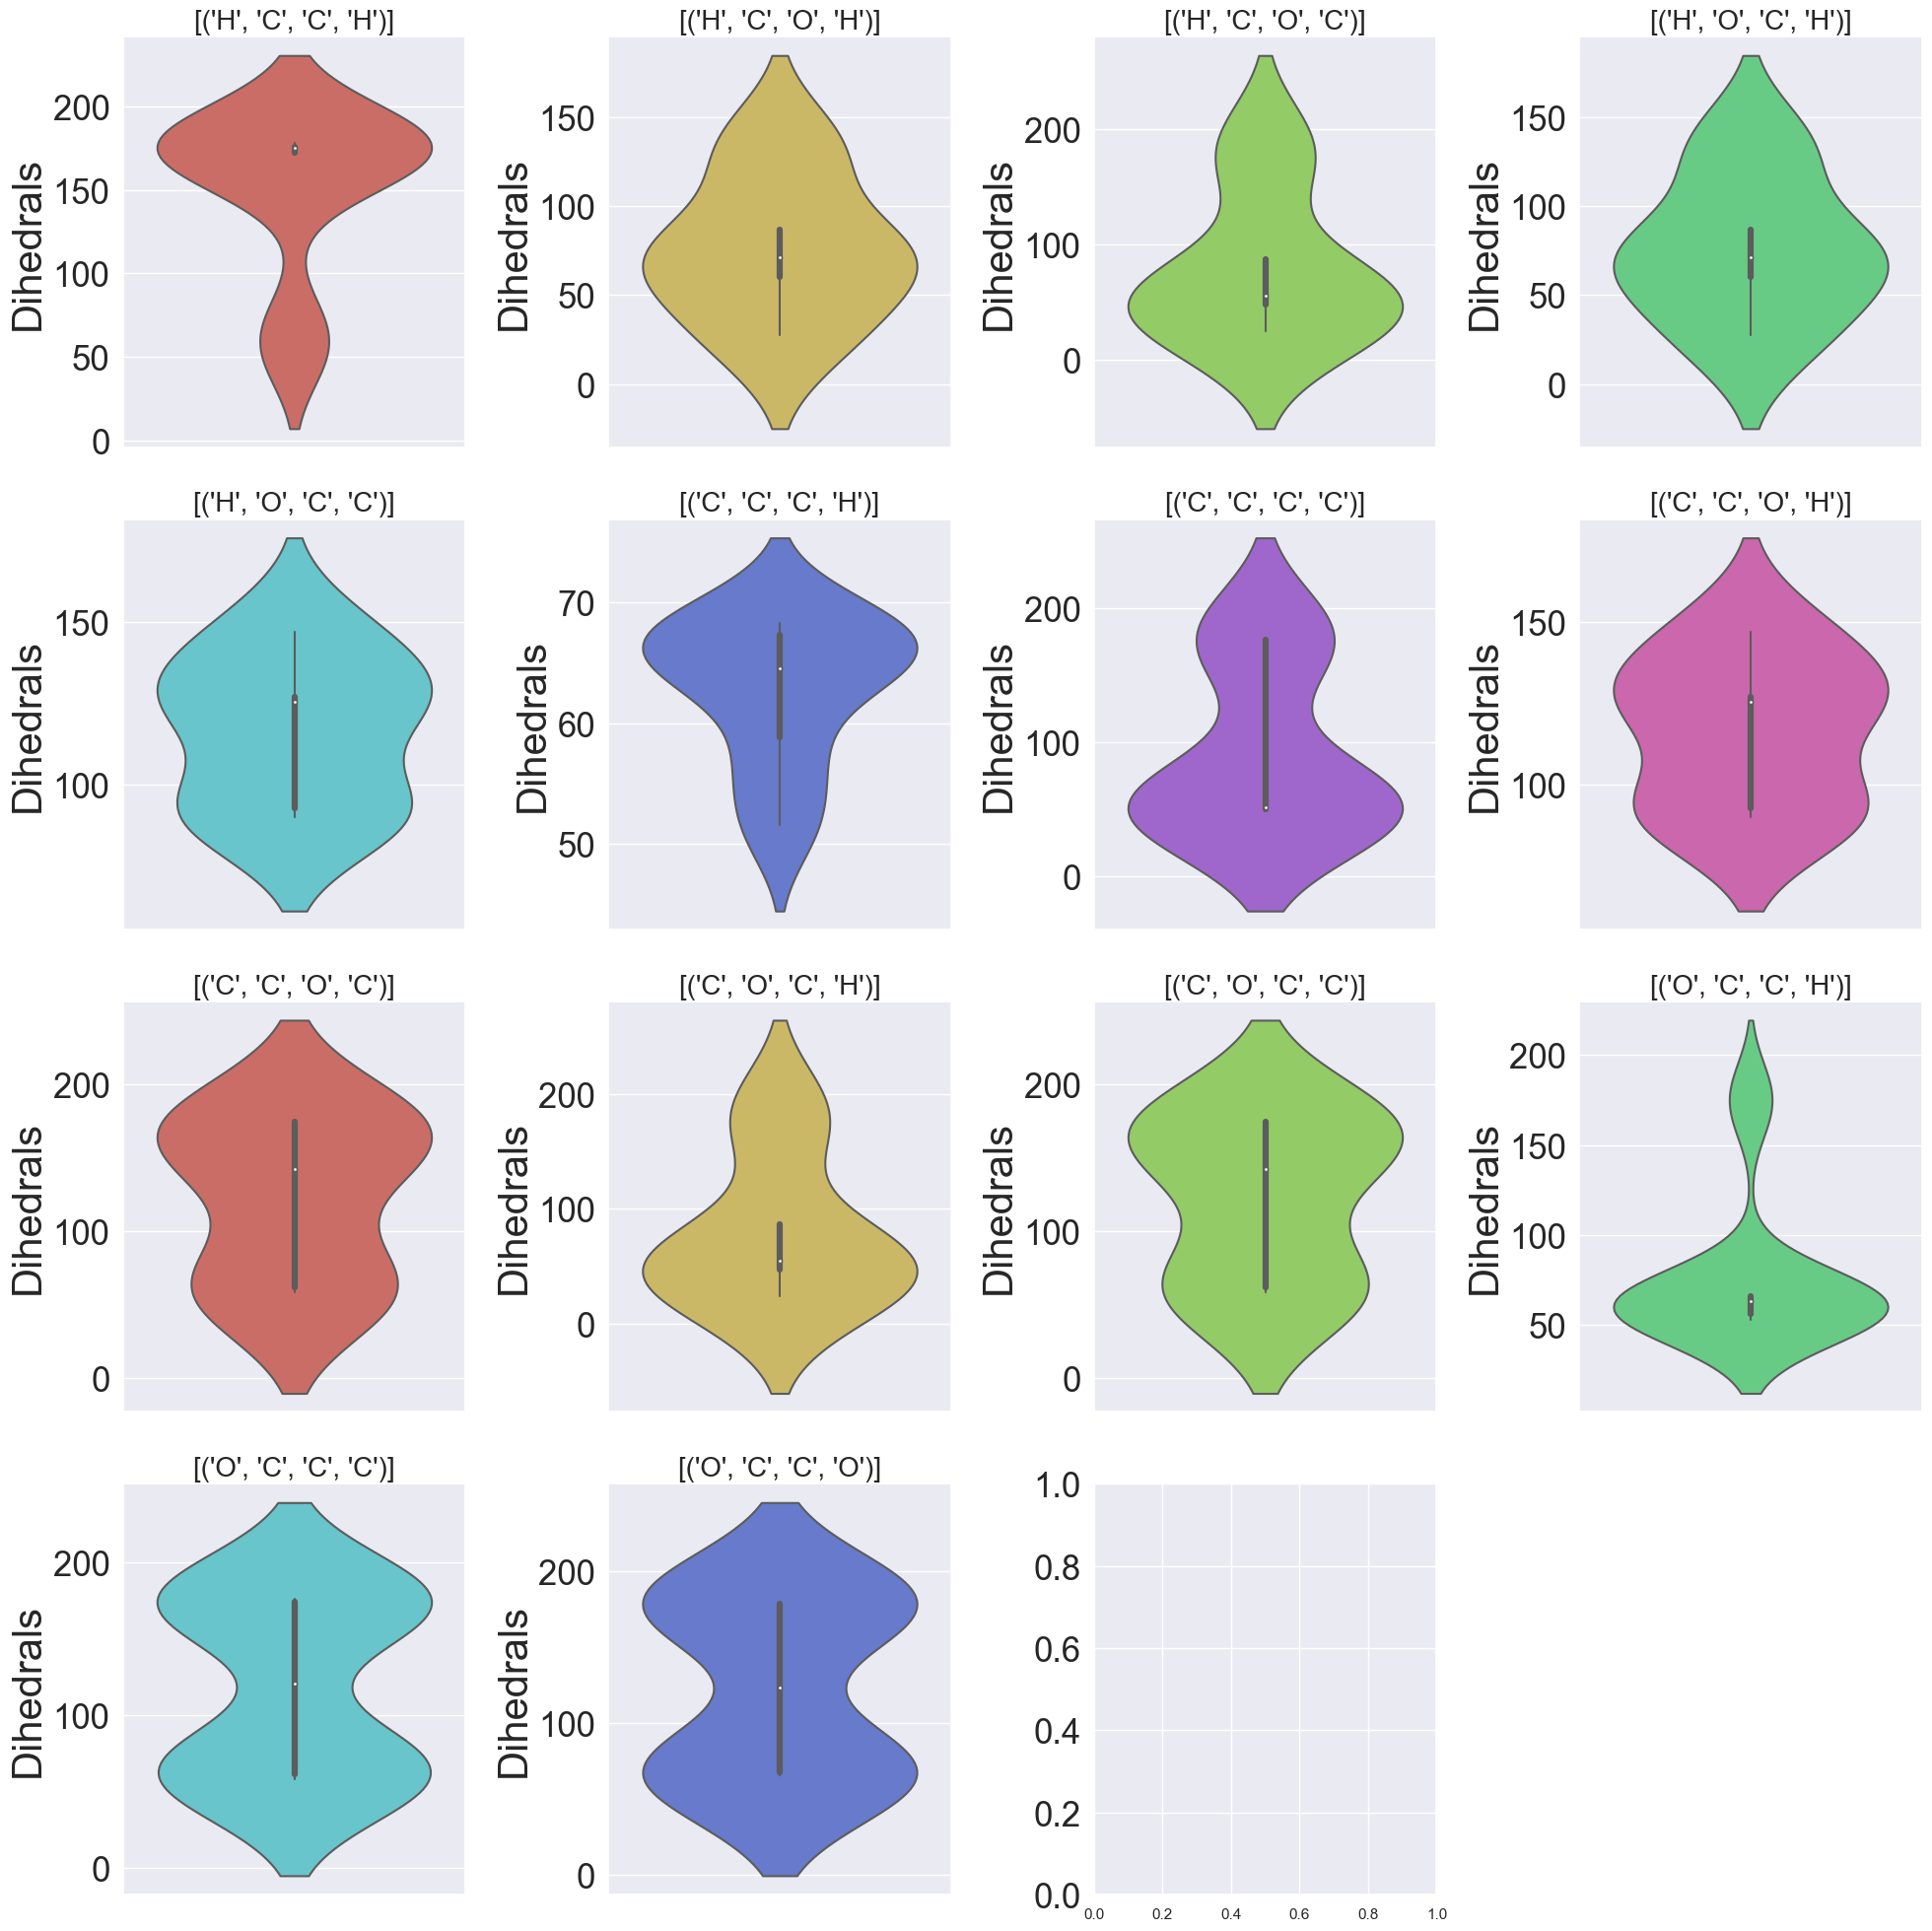

In [8]:
D2.plot_dihedrals()